In [2]:
import pandas as pd
df_exchanges = pd.read_parquet('/home/jovyan/data/crypto_ingestion/processed/exchanges/date=2025-08-10/data.parquet')
print(df_exchanges)

  exchange_id        exchange_name  year_established                 country  \
0     binance              Binance              2017          Cayman Islands   
1        gate                 Gate              2013                  Panama   
2  bybit_spot                Bybit              2018  British Virgin Islands   
3      bitget               Bitget              2018              Seychelles   
4         mxc                 MEXC              2018              Seychelles   
5        okex                  OKX              2017              Seychelles   
6        gdax    Coinbase Exchange              2012           United States   
7      kraken               Kraken              2011           United States   
8       huobi                  HTX              2013              Seychelles   
9  crypto_com  Crypto.com Exchange              2019                   Malta   

   trust_score  trust_score_rank  
0           10                 1  
1           10                 2  
2           10

In [9]:
df_shared_markets = pd.read_parquet('/home/jovyan/data/crypto_ingestion/processed/shared_markets/date=2025-08-09/data.parquet')
print(df_shared_markets)

   exchange_id market_id base target     name
0         okex   ETH_USD  ETH    USD  ETH/USD
1         okex   BTC_USD  BTC    USD  BTC/USD
2         okex   XRP_USD  XRP    USD  XRP/USD
3         gdax   ETH_USD  ETH    USD  ETH/USD
4         gdax   BTC_USD  BTC    USD  BTC/USD
5         gdax   XRP_USD  XRP    USD  XRP/USD
6       kraken   ETH_USD  ETH    USD  ETH/USD
7       kraken   XRP_USD  XRP    USD  XRP/USD
8   crypto_com   ETH_USD  ETH    USD  ETH/USD
9   crypto_com   BTC_USD  BTC    USD  BTC/USD
10  crypto_com   XRP_USD  XRP    USD  XRP/USD


In [12]:
df_market_30day_volume =  pd.read_parquet('/home/jovyan/data/crypto_ingestion/processed/market_30day_volume/date=2025-08-09/data.parquet')
pd.set_option('display.float_format', '{:,.2f}'.format)
print(df_market_30day_volume)

    marked_id            timestamp            volume
0     ETH_USD  2025-07-12 00:00:00 42,455,550,664.55
1     ETH_USD  2025-07-13 00:00:00 17,472,135,946.60
2     ETH_USD  2025-07-14 00:00:00 18,605,172,049.09
3     ETH_USD  2025-07-15 00:00:00 41,336,421,998.04
4     ETH_USD  2025-07-16 00:00:00 43,416,230,283.77
..        ...                  ...               ...
336   XRP_USD  2025-08-07 00:00:00  4,082,166,604.03
337   XRP_USD  2025-08-08 00:00:00  7,757,095,979.62
338   XRP_USD  2025-08-09 00:00:00  8,889,928,900.44
339   XRP_USD  2025-08-10 00:00:00  4,765,475,379.04
340   XRP_USD  2025-08-10 09:38:07  5,208,439,428.91

[341 rows x 3 columns]


In [11]:
df_exchange_30day_volume =  pd.read_parquet('/home/jovyan/data/crypto_ingestion/processed/exchange_30day_volume/date=2025-08-09/data.parquet')
print(df_exchange_30day_volume)

    exchange_id            timestamp         volume
0       binance  2025-07-12 09:30:00  220224.936850
1       binance  2025-07-13 09:30:00  121720.339469
2       binance  2025-07-14 09:30:00  206304.073441
3       binance  2025-07-15 09:30:00  245321.915248
4       binance  2025-07-16 09:30:00  221902.963760
..          ...                  ...            ...
295  crypto_com  2025-08-06 09:30:00   28840.568507
296  crypto_com  2025-08-07 09:30:00   19625.446262
297  crypto_com  2025-08-08 09:30:00   30926.162108
298  crypto_com  2025-08-09 09:30:00   21124.841765
299  crypto_com  2025-08-10 09:20:00   19814.639224

[300 rows x 3 columns]


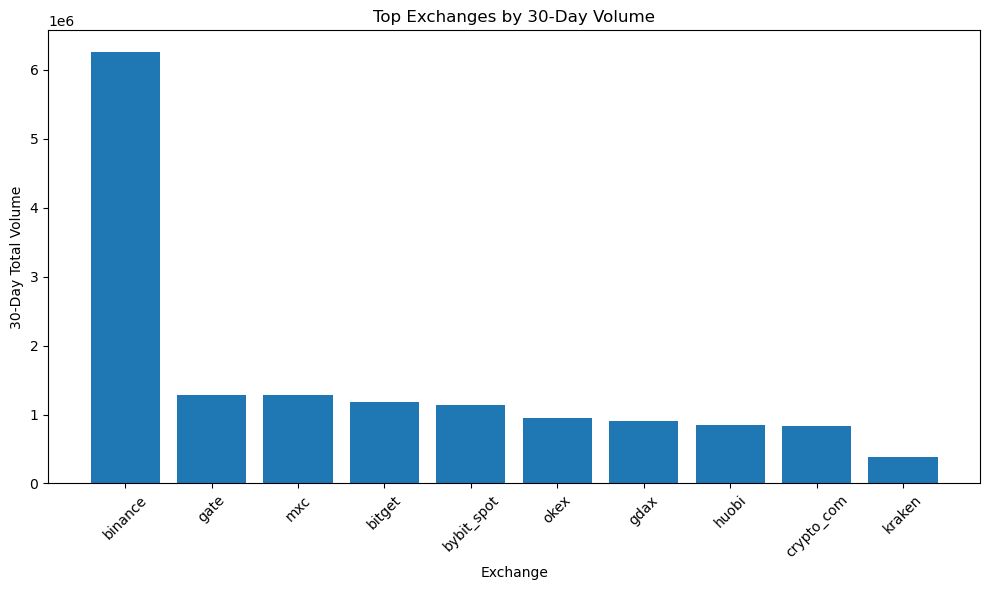

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

total_volume = df_exchange_30day_volume.groupby('exchange_id')['volume'].sum().reset_index()
top_exchanges = total_volume.nlargest(10, 'volume')

plt.figure(figsize=(10,6))
plt.bar(top_exchanges['exchange_id'], top_exchanges['volume'])
plt.xlabel('Exchange')
plt.ylabel('30-Day Total Volume')
plt.title('Top Exchanges by 30-Day Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()